In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/img_align_celeba.zip' -d GAN

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: GAN/img_align_celeba/197600.jpg  
 extracting: GAN/img_align_celeba/197601.jpg  
 extracting: GAN/img_align_celeba/197602.jpg  
 extracting: GAN/img_align_celeba/197603.jpg  
 extracting: GAN/img_align_celeba/197604.jpg  
 extracting: GAN/img_align_celeba/197605.jpg  
 extracting: GAN/img_align_celeba/197606.jpg  
 extracting: GAN/img_align_celeba/197607.jpg  
 extracting: GAN/img_align_celeba/197608.jpg  
 extracting: GAN/img_align_celeba/197609.jpg  
 extracting: GAN/img_align_celeba/197610.jpg  
 extracting: GAN/img_align_celeba/197611.jpg  
 extracting: GAN/img_align_celeba/197612.jpg  
 extracting: GAN/img_align_celeba/197613.jpg  
 extracting: GAN/img_align_celeba/197614.jpg  
 extracting: GAN/img_align_celeba/197615.jpg  
 extracting: GAN/img_align_celeba/197616.jpg  
 extracting: GAN/img_align_celeba/197617.jpg  
 extracting: GAN/img_align_celeba/197618.jpg  
 extracting: GAN/img_align_celeba/197619.jpg  
 extracting: GAN/img_ali

학습용 데이터 셋

In [ ]:
import glob
import torchvision.transforms as tf
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
imgs = glob.glob('/content/GAN/img_align_celeba/*.jpg')
import numpy as np
img_data = np.array(Image.open(imgs[0]))
img_data[:,:,0].reshape(-1),img_data[:,:,1].reshape(-1),img_data[:,:,2].reshape(-1)

(array([32, 32, 32, ..., 72, 50, 44], dtype=uint8),
 array([ 0,  0,  0, ..., 60, 42, 38], dtype=uint8),
 array([ 3,  3,  3, ..., 74, 55, 50], dtype=uint8))

In [ ]:
np.mean(img_data[:,:,0]) / 255,np.mean(img_data[:,:,1]) / 255,np.mean(img_data[:,:,2]) / 255,

(0.3645892580308074, 0.23380781443594859, 0.2289660859705185)

In [ ]:
np.std(img_data[:,:,0]) / 255,np.std(img_data[:,:,1]) / 255,np.std(img_data[:,:,2]) / 255,

(0.3009398850176536, 0.3001665774388843, 0.2837264782602165)

In [ ]:
class CelebA(Dataset):
  def __init__(self,pth = '/content/GAN/img_align_celeba/*.jpg'):
    self.imgs = glob.glob(pth)
    # 입력용 이미지
    self.low_res_tf = tf.Compose([
        tf.Resize((32,32)),
        tf.ToTensor(),
        tf.Normalize((0.36, 0.23, 0.22),(0.30, 0.30, 0.28))
    ])
    # 정답용 이미지
    self.high_res_tf = tf.Compose([
        tf.Resize((64,64)),
        tf.ToTensor(),
        tf.Normalize((0.36, 0.23, 0.22),(0.30, 0.30, 0.28))
    ])
  def __len__(self):
    return len(self.imgs)
  def __getitem__(self, index):
    img = Image.open(self.imgs[index])
    # 저화질 이미지는 입력 후 화질 개선
    img_low_res = self.low_res_tf(img)
    # 고화질 이미지는 정답
    img_high_res = self.high_res_tf(img)

    return img_low_res, img_high_res

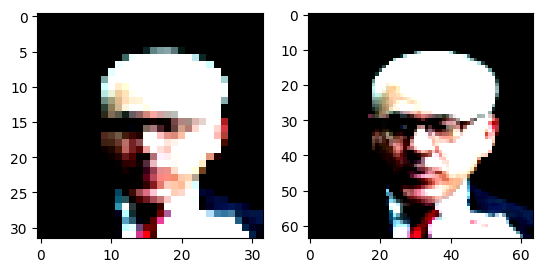

In [ ]:
import matplotlib.pyplot as plt

dataset = CelebA()
low_img, high_img = next(iter(dataset))

plt.subplot(1, 2, 1)
plt.imshow(low_img.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(high_img.permute(1, 2, 0))
plt.show()

생성자

In [ ]:
import torch.nn as nn
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ResidualBlock,self).__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.PReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels)
    )

  def forward(self, x):
    x_ = x
    x = self.layers(x)
    x += x_
    return x

In [ ]:
#(1,3,128,128)
import torch
temp_layer  = nn.Conv2d(3,64,kernel_size=3, stride=1, padding=1)
temp_data = torch.Tensor(range(1*3*32*32)).reshape(1,3,32,32)
temp_layer(temp_data).shape

torch.Size([1, 64, 32, 32])

업 샘플링
- 이미지를 키운다.
- 트랜스 포머스를 이용 안함(가중치 기반의 학습)
- 픽셸셔플(픽셀 위치 재조정)
    - 그전에 이미지의 특성 정보를 취득하기 위해서 conv를 한번 거친다.


In [ ]:
class UpSample(nn.Sequential):
  def __init__(self, in_channels, out_channels):
    super(UpSample, self).__init__(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1,padding=1),
        nn.PixelShuffle(upscale_factor=2),
        nn.PReLU()
    )

In [ ]:
temp_layer = nn.Conv2d(3,64,kernel_size=3, stride=1, padding=1)
temp_data = torch.Tensor(range(1*3*32*32)).reshape(1,3,32,32)
temp_upsample = UpSample(3,64)
print(f"입력데이터 모양:{temp_data.shape}")
print(f"출력데이터 모양:{temp_upsample(temp_data).shape}")

입력데이터 모양:torch.Size([1, 3, 32, 32])
출력데이터 모양:torch.Size([1, 16, 64, 64])


In [ ]:
# 생성자
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(3,64,kernel_size=9,stride=1, padding=4),
      nn.PReLU()
    )
    self.res_block = nn.Sequential(
        ResidualBlock(64,64),
        ResidualBlock(64,64),
        ResidualBlock(64,64)
    )
    self.conv2 = nn.Conv2d(64,64,kernel_size=3,stride=1, padding=1)
    self.bn = nn.BatchNorm2d(64)
    self.upsample_block = nn.Sequential(
        UpSample(64,256)
    )
    self.conv3 = nn.Conv2d(64,3,kernel_size=9,stride=1, padding=4)

  def forward(self, x):
    x = self.conv1(x)
    x_ = x
    x = self.res_block(x)
    x = self.conv2(x)
    x = self.bn(x)
    x += x_
    x = self.upsample_block(x)
    x = self.conv3(x)
    return x

In [ ]:
temp_data = torch.Tensor(range(1*3*32*32)).reshape(1,3,32,32)
g = Generator()
g(temp_data).shape

torch.Size([1, 3, 64, 64])

In [ ]:
class DiscBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DiscBlock, self).__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU()
    )
  def forward(self, x):
    return self.layers(x)

감별자

In [ ]:
# 감별자 정의
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3,64,kernel_size=3, stride=1,padding=1),
        nn.LeakyReLU()
    )
    self.blocks = DiscBlock(64,64)

  def forward(self,x ):
    x = self.conv1(x)
    x = self.blocks(x)
    return x

In [ ]:
temp_model = Discriminator()
temp_g = Generator()
# 저화질 32,32 를 생성자에 입력해서 나온 이미지를 감별자에 넣는다.
# (1,3,32,32)
temp_tensor = torch.Tensor(np.array(range(1*3*32*32)).reshape(1,3,32,32))
gen = temp_g(temp_tensor)
print(gen.shape)
dis = temp_model(gen)
print(dis.shape), 64*32*32

torch.Size([1, 3, 64, 64])
torch.Size([1, 64, 32, 32])


(None, 65536)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3,64,kernel_size=3, stride=1,padding=1),
        nn.LeakyReLU()
    )
    self.blocks = DiscBlock(64,64)

    # 평탄화  65536
    self.fc1 = nn.Linear(64*32*32, 1024)
    self.activation = nn.LeakyReLU()
    self.fc2 = nn.Linear(1024, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self,x ):
    x = self.conv1(x)
    x = self.blocks(x)
    # 평탄화(batchsize,channel,width,heigh)
    x = torch.flatten(x,start_dim=1)
    x = self.fc1(x)
    x = self.activation(x)
    x = self.fc2(x)
    x = self.sigmoid(x)

    return x

In [ ]:
dis = Discriminator()
dis_output =  dis(gen)
dis_output.shape

torch.Size([1, 1])

CNN
- 특별한 게 없어서, 전이학습을 사용함 VGG19

In [ ]:
import torch
from torchvision.models.vgg import vgg19,VGG19_Weights

In [ ]:
vgg19_model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
list(vgg19_model.features.children())[:9]

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:10<00:00, 57.0MB/s]


[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True)]

In [ ]:
def temp_func(a1,a2,a3,a4,a5,a6,a7,a8,a9):
  print(a1)

temp_func( *list(vgg19_model.features.children())[:9] )

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
class FeatureExtractor(nn.Module):
  def __init__(self):
    super(FeatureExtractor,self).__init__()
    vgg19_model = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
    self.feature_extractor = nn.Sequential(
        *list(vgg19_model.features.children())[:9]
    )
  def forward(self, x):
    return self.feature_extractor(x)

In [ ]:
temp_model  = FeatureExtractor()
temp_g = Generator()
# 저화질 32,32 를 생성자에 입력해서 나온 이미지를 감별자에 넣는다.
# (1,3,32,32)
temp_tensor = torch.Tensor(np.array(range(1*3*32*32)).reshape(1,3,32,32))
gen = temp_g(temp_tensor)

print(gen.shape)


temp_model(gen).shape

torch.Size([1, 3, 64, 64])


torch.Size([1, 128, 32, 32])

학습

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim.adam import Adam
device = "cuda" if torch.cuda.is_available() else 'cpu'
dataset = CelebA()
batch_size = 8
loader = DataLoader(dataset, batch_size=batch_size, shuffle = True)

In [ ]:
# 생성자 감별자 객체 생성
G = Generator().to(device)
D = Discriminator().to(device)

feature_extractor = FeatureExtractor().to(device)

# 평가모드로 전환
feature_extractor.eval()

G_optim = Adam(G.parameters(), lr = 1e-4)
D_optim = Adam(D.parameters(), lr = 1e-4)

In [ ]:
# # 학습
# import tqdm
# for epoch in range(1):
#   iterator = tqdm.tqdm(loader)
#   for low_res, high_res in iterator:
#     # 기울기 초기화
#     G_optim.zero_grad()
#     D_optim.zero_grad()
#     # 진짜와 가짜의 정답 데이터
#     label_true = torch.ones(batch_size, dtype = torch.float32).to(device)
#     label_false = torch.zeros(batch_size, dtype = torch.float32).to(device)
#     # 생성자 학습
#     fake_hr = G(low_res.to(device))# 생성자가 만든 이미지를 감별자에 넣어서 결과로 1을 얻으려함
#     GAN_loss = nn.MSELoss()( D(fake_hr), label_true)

#     # 특징 추출
#     fake_feature = feature_extractor(fake_hr)
#     real_feature = feature_extractor(high_res.to(device))
#     content_loss = nn.L1Loss()(fake_feature, real_feature)

#     # 생성자의 손실
#     # GAN_loss 계수가 작을 수록 이미지 왜곡은 없지만 해상도는 낮아지고
#     # GAN_loss 계수가 크면 해상도는 높아지지만 이미지 왜곡현상
#     logg_G = content_loss + 0.001*GAN_loss
#     logg_G.backward()
#     G_optim.step()

#     # 감별자 학습
#     real_loss = nn.MSELoss()( D(high_res.to(device)), label_true )
#     fake_loss = nn.MSELoss()( D(fake_hr.detach()), label_false )
#     loss_D = (real_loss + fake_loss)
#     loss_D.backward()
#     D_optim.step()

#     iterator.set_description(f'epoch:{epoch+1} G_loss:{GAN_loss} D_loss:{loss_D}')

# # 결과 저장
# torch.save(G.state_dict(),'/content/drive/MyDrive/SRGAN_G.pth')
# torch.save(D.state_dict(),'/content/drive/MyDrive/SRGAN_D.pth')

평가

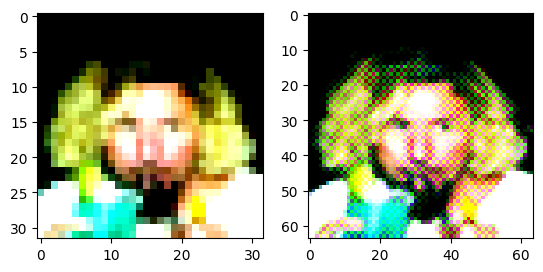

In [ ]:
import matplotlib.pyplot as plt
G.load_state_dict(torch.load('/content/drive/MyDrive/SRGAN_G.pth',map_location=device) )
with torch.no_grad():
  low_res,high_res =  dataset[50]

  # 생성자의 입력 torch.Size([3, 32, 32]) -> 1,3,32,32
  input_tensor = torch.unsqueeze(low_res, dim=0).to(device)
  # 생성자 출력 -> 4차원
  pred = G(input_tensor)
  # 시각화를 위해서 shape모양을 조정
  pred = pred.squeeze()
  pred = pred.permute(1,2,0).cpu().numpy() # (채널, 가로 ,세로) --> (가로, 세로, 채널)
  low_res = low_res.permute(1,2,0).numpy()

  plt.subplot(1,2,1)
  plt.imshow(low_res)
  plt.subplot(1,2,2)
  plt.imshow(pred)

  plt.show()

In [ ]:
# 테스트 이미지는 인터넷에서 다운 받
testdataset = CelebA('/content/drive/MyDrive/srgan_test_img.jpeg')

array([[[145, 163, 175],
        [145, 163, 175],
        [146, 164, 176],
        ...,
        [134, 144, 146],
        [132, 142, 144],
        [129, 139, 141]],

       [[144, 162, 174],
        [144, 162, 174],
        [145, 163, 175],
        ...,
        [137, 147, 149],
        [134, 144, 146],
        [131, 141, 143]],

       [[142, 160, 172],
        [143, 161, 173],
        [144, 162, 174],
        ...,
        [141, 151, 152],
        [138, 148, 149],
        [135, 145, 146]],

       ...,

       [[122, 154, 175],
        [122, 154, 175],
        [122, 154, 177],
        ...,
        [104, 123, 138],
        [104, 123, 138],
        [104, 123, 138]],

       [[119, 151, 172],
        [119, 151, 172],
        [119, 151, 174],
        ...,
        [105, 124, 139],
        [105, 124, 139],
        [105, 124, 139]],

       [[114, 149, 169],
        [114, 149, 169],
        [114, 149, 171],
        ...,
        [105, 124, 139],
        [105, 124, 139],
        [105, 124, 139]]], dtype=uint8)
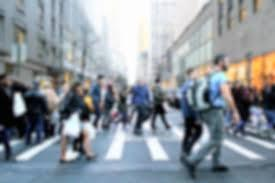

In [ ]:
img = Image.open('/content/drive/MyDrive/srgan_test_img.jpeg')
np.array(img)

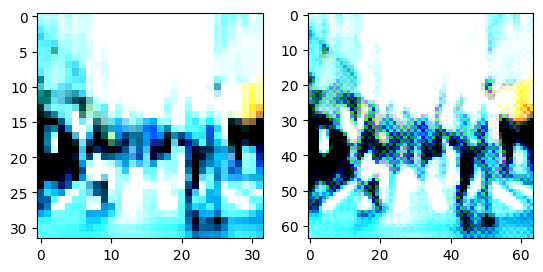

In [ ]:
with torch.no_grad():
  low_res,high_res =  testdataset[0]

  # 생성자의 입력 torch.Size([3, 32, 32]) -> 1,3,32,32
  input_tensor = torch.unsqueeze(low_res, dim=0).to(device)
  # 생성자 출력 -> 4차원
  pred = G(input_tensor)
  # 시각화를 위해서 shape모양을 조정
  pred = pred.squeeze()
  pred = pred.permute(1,2,0).cpu().numpy() # (채널, 가로 ,세로) --> (가로, 세로, 채널)
  low_res = low_res.permute(1,2,0).numpy()

  plt.subplot(1,2,1)
  plt.imshow(low_res)
  plt.subplot(1,2,2)
  plt.imshow(pred)

  plt.show()